# Libraries

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]=""

import numpy as np

import matplotlib.pyplot as plt

import cv2
from PIL import Image

from torch import nn
from torchvision import transforms
from einops.layers.torch import Rearrange

import torch

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 1. Visualization of Patches

## 1.1 Plot Sample Image

Sample is H = 224 and W = 224 pixels.


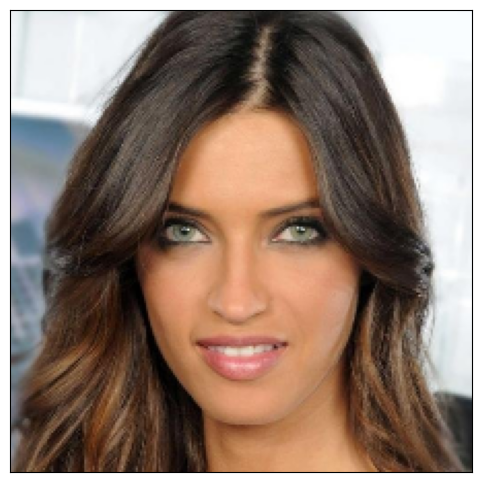

In [5]:
sample = cv2.imread("..//sample.jpg")
shape = (224,224)
sample = cv2.resize(sample,shape)
sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)

H = sample.shape[0]
W = sample.shape[1]
print('Sample is H =', H, 'and W =', W, 'pixels.')

fig = plt.figure(figsize=(10,6))
plt.imshow(sample)
plt.xticks([])
plt.yticks([])
plt.show()

## 1.2 Num of Patches

In [6]:
aux = []
for i in range(1,H):
    if(H%i == 0):
        aux.append(i)
print(aux)

[1, 2, 4, 7, 8, 14, 16, 28, 32, 56, 112]


There will be 196 patches, each 16 by 16.




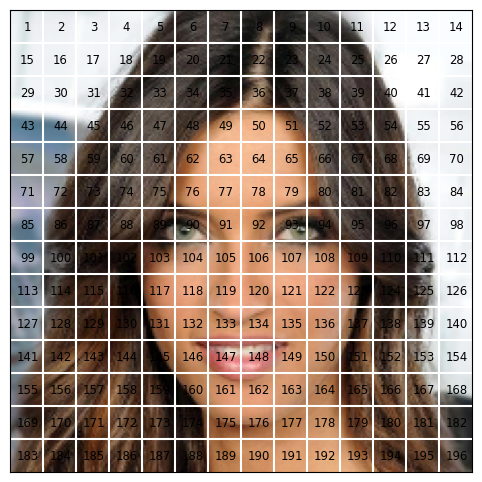

In [7]:
patch_size = 16
num_patches = int((H*W)/(patch_size**2))
print('There will be', num_patches, 'patches, each', patch_size, 'by', str(patch_size)+'.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(sample, cmap='Purples_r')
plt.hlines(np.arange(patch_size, H, patch_size)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(patch_size, W, patch_size)-0.5, -0.5, H-0.5, color='w')
plt.xticks([])
plt.yticks([])

text = np.linspace(int(patch_size/2), W - int(patch_size/2), int(num_patches**0.5))

num = 1
for text_i in text:
    for text_j in text:
        plt.text(text_j,text_i, str(num), color='black', fontsize='small', ha='center',va='center')
        num +=1
#plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center');
#plt.savefig(os.path.join(figure_path, 'mountain_patches.png'), bbox_inches='tight'

# 2. Patch Tokenization

In [4]:
class Patch_Tokenization(nn.Module):
    def __init__(self,
                img_size: tuple[int, int, int]=(1, 1, 60, 100),
                patch_size: int=50,
                token_len: int=768):

        """ Patch Tokenization Module
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
        """
        super().__init__()

        ## Defining Parameters
        self.img_size = img_size
        B, C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
        assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'
        self.num_tokens = (H / self.patch_size) * (W / self.patch_size)

        ## Defining Layers
        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0)
        self.project = nn.Linear((self.patch_size**2)*C, token_len)

    def forward(self, x):
        x = self.split(x).transpose(2,1)
        x = self.project(x)
        return x

## 2.1 Applying tokenize

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize the image to 256x256 pixels
    transforms.ToTensor(),            # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [3]:
image = Image.open("./sample.jpg")


image_transform = transform(image)
image_transform = image_transform.unsqueeze(0)
image_transform = torch.cat([image_transform]*7)

In [8]:
patch_tokenization = Patch_Tokenization(
    img_size=image_transform.shape,
    patch_size=patch_size,
    token_len=512
)
image_token = patch_tokenization(image_transform)

#image_token = 

print(image_token.shape)
print(image_token)

torch.Size([7, 196, 512])
tensor([[[ 0.3288, -0.3169,  0.1879,  ...,  0.7731,  0.2542,  1.5354],
         [ 0.4269, -0.3178,  0.2672,  ...,  0.7063,  0.2499,  1.5707],
         [ 0.4032, -0.3315,  0.2113,  ...,  0.7855,  0.2473,  1.6297],
         ...,
         [-0.5581,  0.1047, -0.1132,  ..., -0.3667, -0.2127, -0.6632],
         [ 0.2351,  0.1725,  0.0429,  ..., -0.5896,  0.0261, -0.7136],
         [ 0.0610,  0.1645, -0.0190,  ..., -0.4334, -0.2507, -0.5641]],

        [[ 0.3288, -0.3169,  0.1879,  ...,  0.7731,  0.2542,  1.5354],
         [ 0.4269, -0.3178,  0.2672,  ...,  0.7063,  0.2499,  1.5707],
         [ 0.4032, -0.3315,  0.2113,  ...,  0.7855,  0.2473,  1.6297],
         ...,
         [-0.5581,  0.1047, -0.1132,  ..., -0.3667, -0.2127, -0.6632],
         [ 0.2351,  0.1725,  0.0429,  ..., -0.5896,  0.0261, -0.7136],
         [ 0.0610,  0.1645, -0.0190,  ..., -0.4334, -0.2507, -0.5641]],

        [[ 0.3288, -0.3169,  0.1879,  ...,  0.7731,  0.2542,  1.5354],
         [ 0.4269, 

# 3. Build Vision Transformer Model

In [78]:
def get_sinusoid_encoding(num_tokens, token_len):
        """ Make Sinusoid Encoding Table
    
            Args:
                num_tokens (int): number of tokens
                token_len (int): length of a token
                
            Returns:
                (torch.FloatTensor) sinusoidal position encoding table
        """
    
        def get_position_angle_vec(i):
            return [i / np.power(10000, 2 * (j // 2) / token_len) for j in range(token_len)]
    
        sinusoid_table = np.array([get_position_angle_vec(i) for i in range(num_tokens)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) 
    
        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

class Patch_Tokenization(nn.Module):
    def __init__(self,
                patch_size: int=50,
                token_len: int=768,
                channels: int=3):

        """ Patch Tokenization Module
            Args:
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
        """
        super().__init__()
        self.patch_size = patch_size
        self.token_len = token_len
        self.channels = channels

        ## Defining Layers
        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0)
        self.project = nn.Linear((self.patch_size**2)*self.channels, token_len)

    def forward(self, x):
        x = self.split(x).transpose(2,1)
        x = self.project(x)
        return x

class VisionModel(nn.Module):
    def __init__(self, img_size, patch_size, token_len, embed_dim=512, num_heads=8, num_layers=6):
        super(VisionModel, self).__init__()
        
        ## Defining Parameters
        self.img_size = img_size
        B, C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len
        assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
        assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'
        self.num_tokens = (H // self.patch_size) * (W // self.patch_size)
        
        self.patch_tokenization = Patch_Tokenization(
                patch_size=patch_size,
                token_len=token_len,
                channels=C
            )
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.token_len))
        self.emb_posi = nn.Parameter(
            data=get_sinusoid_encoding(self.num_tokens+1, self.token_len),
            requires_grad=False
        )

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.linear = nn.Linear(self.token_len,(self.patch_size**2)*C)
        self.final_layer = nn.Linear((self.patch_size**2)*C,C*H*W)
        #self.fold = nn.Fold(output_size=(H, W), kernel_size=(self.patch_size,self.patch_size),stride=(self.patch_size,self.patch_size))

    
    def forward(self,x):
        image_token = self.patch_tokenization(x)
        
        B, N, E = image_token.shape
        tokens = self.cls_token.expand(B,-1,-1)
        image_token = torch.cat((tokens,image_token),dim=1)
        image_token += self.emb_posi
        image_token = image_token.permute(1,0,2)

        out_encode = self.transformer_encoder(image_token)

        # Transformer decoder
        #decoder_input = self.linear(out_encode[0])  # Take the cls token output (1, B, E)
        decoder_input = out_encode[0,:,:]
        decoder_input = decoder_input.unsqueeze(0)  # Add a time dimension
        decoder_output = self.transformer_decoder(out_encode, decoder_input)  # (N, B, E)
        
        # Final linear layer for image reconstruction
        x = decoder_output[0,:,:]
        x = self.linear(x)
        x = self.final_layer(x)

        _, C, H, W = self.img_size
        
        x = x.reshape(-1,C,H,W)
        
        
        return x
        
        #return out_encode

## 3.1 Applying model

In [79]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize the image to 256x256 pixels
    transforms.ToTensor(),            # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

image = Image.open("../sample.jpg")


image_transform = transform(image)
image_transform = image_transform.unsqueeze(0)
image_transform = torch.cat([image_transform]*7)

In [80]:
vision_model = VisionModel(img_size=(7,3,224,224),patch_size=16,token_len=512)

In [81]:
out = vision_model(image_transform)

In [82]:
out.shape

torch.Size([7, 3, 224, 224])

In [ ]:
plt.imshow(out[0].permute(1, 2, 0).detach().numpy())

# 4. Einops vs Unfold

## 4.1 Abrindo imagem

In [19]:
image = Image.open("../sample.jpg")

image_transform = transform(image)
image_transform = image_transform.unsqueeze(0)

## 4.2 Unfold

In [22]:
unfold = nn.Unfold(kernel_size=16, stride=16, padding=0)

In [24]:
img_unfold = unfold(image_transform)

In [25]:
img_unfold.shape

torch.Size([1, 768, 196])

## 4.3 Einops

In [27]:
einops_rearrange = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)

In [33]:
img_einops = einops_rearrange(image_transform)

In [34]:
img_einops.shape

torch.Size([1, 196, 768])

## 4.4 Comparação

In [40]:
img_unfold_t = img_unfold.transpose(2,1)

In [43]:
img_unfold_t.shape

torch.Size([1, 196, 768])

In [42]:
img_unfold_t == img_einops

tensor([[[ True, False, False,  ..., False, False,  True],
         [ True, False, False,  ..., False, False,  True],
         [ True, False, False,  ..., False, False,  True],
         ...,
         [ True, False, False,  ..., False, False,  True],
         [ True, False, False,  ..., False, False,  True],
         [ True, False, False,  ..., False, False,  True]]])

# 5. Refatoração do modelo Transformer

## 5.1 Transformação da imagem

In [2]:
from torchvision.transforms import v2

transform = v2.Compose([  
     v2.Resize((224, 224)),
     v2.PILToTensor(),
     v2.ToDtype(torch.float32, scale=True)                                                                     
])

## 5.2 Abrindo imagem

In [3]:
image_list = [transform(Image.open(path)) for path in ["../sample.jpg","../sample2.jpg","../sample3.jpg"]]
image_transform = torch.stack(image_list)

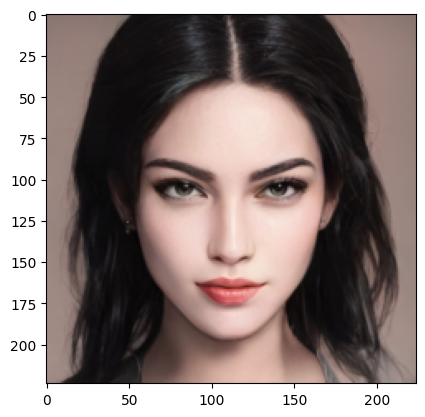

In [4]:
plt.imshow(image_transform[-2].permute(1,2,0))
plt.show()

In [59]:
image_transform[0]

tensor([[[0.9216, 0.9216, 0.9176,  ..., 0.9686, 0.9686, 0.9686],
         [0.9255, 0.9255, 0.9216,  ..., 0.9725, 0.9725, 0.9725],
         [0.9294, 0.9294, 0.9255,  ..., 0.9765, 0.9765, 0.9765],
         ...,
         [0.5059, 0.4784, 0.4235,  ..., 0.2118, 0.1843, 0.1647],
         [0.4980, 0.4706, 0.4000,  ..., 0.2745, 0.2392, 0.2118],
         [0.4902, 0.4510, 0.3686,  ..., 0.3451, 0.3255, 0.3059]],

        [[0.9373, 0.9373, 0.9373,  ..., 0.9843, 0.9843, 0.9843],
         [0.9412, 0.9412, 0.9412,  ..., 0.9882, 0.9882, 0.9882],
         [0.9451, 0.9451, 0.9451,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.4510, 0.4196, 0.3529,  ..., 0.2118, 0.1843, 0.1569],
         [0.4392, 0.4078, 0.3255,  ..., 0.2706, 0.2353, 0.2000],
         [0.4235, 0.3804, 0.2902,  ..., 0.3412, 0.3176, 0.2902]],

        [[0.9490, 0.9490, 0.9490,  ..., 0.9961, 0.9961, 0.9961],
         [0.9529, 0.9529, 0.9529,  ..., 1.0000, 1.0000, 1.0000],
         [0.9569, 0.9569, 0.9569,  ..., 1.0000, 1.0000, 1.

## 5.3 Definindo modelo

In [60]:
import sys
sys.path.append("/home/lucas/Documentos/Image-Denoising/src/")

In [61]:
from models.transformer_torch import VisionModel

In [62]:
model = VisionModel(
    img_size=(3,3,224,224),
    patch_size=16,
    token_len=512,
    embed_dim=512
)

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [63]:
image_transform.shape

torch.Size([3, 3, 224, 224])

In [64]:
output = model(image_transform)

In [65]:
output.shape

torch.Size([3, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5561131..1.5812598].


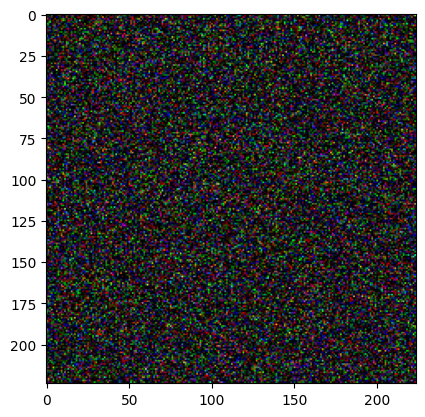

In [69]:
plt.imshow(output[2].permute(1,2,0).detach().numpy())
plt.show()

In [70]:
loss = nn.MSELoss(reduction='none')

In [71]:
out_loss = loss(output,image_transform)

In [72]:
out_loss.shape

torch.Size([3, 3, 224, 224])

In [75]:
out_mean = torch.mean(out_loss, dim=1)
out_mean

tensor([[[0.8616, 0.9979, 1.1264,  ..., 1.7941, 1.2509, 0.7880],
         [1.6043, 1.4193, 1.2533,  ..., 1.2130, 0.7362, 0.4371],
         [1.3019, 0.8293, 1.1009,  ..., 0.5744, 1.8506, 1.4842],
         ...,
         [0.2977, 0.0183, 0.1760,  ..., 0.2726, 0.1574, 0.1960],
         [0.4803, 0.0142, 0.0953,  ..., 0.1026, 0.2160, 0.1097],
         [0.2611, 0.1134, 0.0884,  ..., 0.2709, 0.2275, 0.1038]],

        [[0.3575, 0.2930, 0.5090,  ..., 0.6090, 0.4267, 0.1102],
         [0.7407, 0.6730, 0.6513,  ..., 0.4009, 0.0748, 0.1117],
         [0.4625, 0.2962, 0.3957,  ..., 0.0997, 0.5578, 0.5082],
         ...,
         [0.2394, 0.0411, 0.3329,  ..., 0.7341, 0.3792, 0.2368],
         [0.6378, 0.0988, 0.4431,  ..., 0.0115, 0.3954, 0.3095],
         [0.3123, 0.3795, 0.3226,  ..., 0.3099, 0.2794, 0.3145]],

        [[0.8195, 1.0396, 1.3200,  ..., 1.6956, 1.1274, 0.8893],
         [1.5635, 1.3985, 1.7171,  ..., 1.1024, 0.4890, 0.3430],
         [1.2103, 0.7691, 1.1546,  ..., 0.4516, 1.5631, 1.

In [76]:
out_mean.shape

torch.Size([3, 224, 224])

In [77]:
torch.sum(out_mean, dim=0).sum(dim=1).mean()

tensor(324.7242, grad_fn=<MeanBackward0>)

In [78]:
import torch.nn.functional as F

class MSELossMine(nn.MSELoss):
    def __init__(self):
        super().__init__()

    def forward(self,input_,target_):
        tensor = F.mse_loss(input_, target_, reduction='none')
        tensor = torch.mean(tensor, dim=1)
        tensor = torch.sum(tensor, dim=0).sum(dim=1).mean()
        return tensor
        
        

In [79]:
my_loss = MSELossMine()

In [80]:
my_loss(output,image_transform)

tensor(324.7242, grad_fn=<MeanBackward0>)

In [68]:
x.shape

torch.Size([1, 196, 768])

In [39]:
from einops.layers.torch import Rearrange

In [64]:
rea = Rearrange('b (h w) (p1 p2 c) -> b c (h p1) (w p2)', p1=16, p2=16,h=14,w=14)

In [81]:
norm = nn.LayerNorm([3,224,224])

In [86]:
img_reversed = rea(x)

In [87]:
img_reversed.shape

torch.Size([1, 3, 224, 224])

In [82]:
img_reversed = norm(img_reversed)

In [85]:
sigmoid = nn.Sigmoid()

In [89]:
img_reversed = sigmoid(img_reversed)

In [90]:
img_reversed

tensor([[[[0.2580, 0.5547, 0.4193,  ..., 0.4000, 0.7294, 0.5625],
          [0.4643, 0.7153, 0.5051,  ..., 0.4526, 0.6171, 0.6066],
          [0.4737, 0.3528, 0.4021,  ..., 0.4885, 0.3715, 0.3274],
          ...,
          [0.4377, 0.6450, 0.5497,  ..., 0.1909, 0.7134, 0.6921],
          [0.4503, 0.3877, 0.3608,  ..., 0.4331, 0.6249, 0.6323],
          [0.5600, 0.5701, 0.3344,  ..., 0.4551, 0.7335, 0.6580]],

         [[0.5177, 0.5801, 0.4806,  ..., 0.3652, 0.3324, 0.7265],
          [0.6641, 0.4387, 0.6012,  ..., 0.4789, 0.4820, 0.5131],
          [0.4136, 0.4204, 0.3523,  ..., 0.5386, 0.5543, 0.3934],
          ...,
          [0.4571, 0.5193, 0.5301,  ..., 0.6646, 0.6864, 0.6131],
          [0.3977, 0.4905, 0.5545,  ..., 0.5278, 0.4256, 0.5059],
          [0.2795, 0.3363, 0.6179,  ..., 0.4113, 0.4272, 0.6784]],

         [[0.5199, 0.4438, 0.4591,  ..., 0.5093, 0.7593, 0.5582],
          [0.4552, 0.5977, 0.5023,  ..., 0.4590, 0.5449, 0.3783],
          [0.4586, 0.0929, 0.5062,  ..., 0

In [84]:
img_reversed

tensor([[[[-1.8706,  0.3534, -0.5969,  ..., -0.7361,  1.6992,  0.4085],
          [-0.2788,  1.5768,  0.0063,  ..., -0.3609,  0.8026,  0.7252],
          [-0.2127, -1.0865, -0.7203,  ..., -0.1097, -0.9459, -1.2840],
          ...,
          [-0.4656,  1.0113,  0.3186,  ..., -2.5462,  1.5603,  1.3828],
          [-0.3766, -0.8256, -1.0258,  ..., -0.4987,  0.8603,  0.9156],
          [ 0.3912,  0.4630, -1.2291,  ..., -0.3429,  1.7354,  1.1112]],

         [[ 0.0940,  0.5343, -0.1642,  ..., -0.9931, -1.2446,  1.6731],
          [ 1.1590, -0.4588,  0.6860,  ..., -0.1763, -0.1549,  0.0618],
          [-0.6375, -0.5887, -1.0903,  ...,  0.2402,  0.3505, -0.7837],
          ...,
          [-0.3288,  0.1051,  0.1809,  ...,  1.1623,  1.3358,  0.7733],
          [-0.7528, -0.0955,  0.3524,  ...,  0.1645, -0.5519,  0.0120],
          [-1.6797, -1.2139,  0.8087,  ..., -0.6543, -0.5404,  1.2717]],

         [[ 0.1097, -0.4227, -0.3149,  ...,  0.0360,  1.9733,  0.3783],
          [-0.3423,  0.6605, -

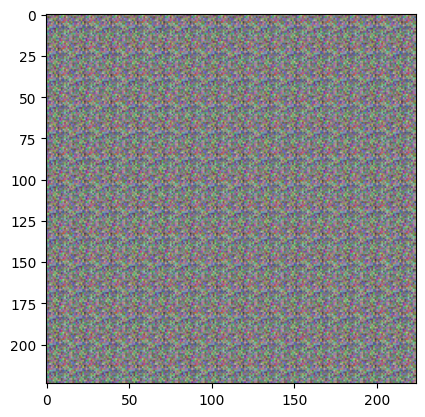

In [91]:
plt.imshow(img_reversed[0].permute(1,2,0).detach().numpy())
plt.show()

# 6. Modelos MAE

In [1]:
import sys
sys.path.append("/home/lucas/Documentos/Image-Denoising/src")

from models.model_mae import MaskedAutoencoderViT

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
model = MaskedAutoencoderViT()

In [10]:
image_transform[0].shape

torch.Size([3, 224, 224])

In [24]:
img = model(image_transform[0].unsqueeze(0))

In [28]:
img_un = model.unpatchify(img[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5077205..3.210909].


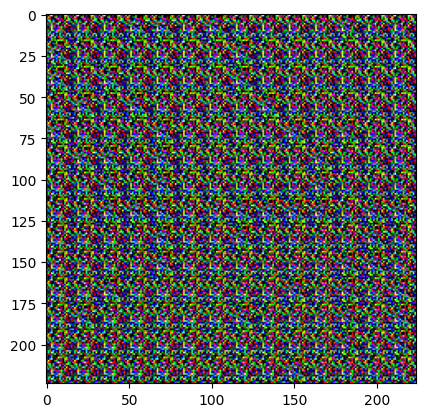

In [32]:
plt.imshow(img_un[0].permute(1,2,0).detach().numpy())

In [33]:
img

(tensor(1.0286, grad_fn=<DivBackward0>),
 tensor([[[-1.1756e+00, -1.5951e+00,  1.1911e+00,  ..., -7.6433e-01,
            7.4029e-01, -6.6343e-01],
          [-1.2476e+00, -1.5853e+00,  1.0601e+00,  ..., -6.6647e-01,
            6.6198e-01, -5.2264e-01],
          [-1.2390e+00, -1.4973e+00,  1.0168e+00,  ..., -4.8676e-01,
            6.3590e-01, -4.7073e-01],
          ...,
          [-8.3108e-01, -1.8113e+00,  9.4015e-01,  ..., -8.4644e-02,
            7.9270e-01, -1.6229e-01],
          [-1.0153e+00, -1.7989e+00,  8.1684e-01,  ...,  7.3643e-02,
            7.5163e-01,  7.6447e-05],
          [-1.1074e+00, -1.8660e+00,  6.2803e-01,  ...,  1.7624e-01,
            7.3548e-01,  1.8810e-01]]], grad_fn=<SliceBackward0>),
 tensor([[1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
          1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
          1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
          1., 1., 0., 1., 1

# 7. Modelo MAE mine

In [5]:
import sys
sys.path.append("/home/lucas/Documentos/Image-Denoising/src")

from models.vision_transformer import VisionModel

In [6]:
model = VisionModel(
    img_size=(3,3,224,224),
    patch_size=16,
    token_len=512,
    embed_dim=512
)

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
res = model(image_transform)

In [8]:
res.shape

torch.Size([3, 197, 768])

In [9]:
teste = res[:,:-1,:]
teste.shape

torch.Size([3, 196, 768])

In [10]:
teste = model.unpatch_tokenization(teste)

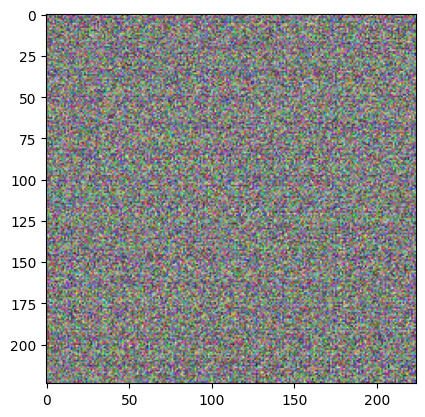

In [11]:
plt.imshow(teste[0].permute(1,2,0).detach().numpy())